<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.isna().sum() # Посмотрим пропуски.

num_orders    0
dtype: int64

In [7]:
data.sort_index(inplace=True)

In [8]:
data = data.resample('1H').sum() # ресемплирование по одному часу

In [9]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Загрузили данные и посмотрели их. Пропусков обнаружино небыло, а поиск дубликатов тут излишне из за специфики датосета. Выполнили ресемплирование по одному часу. 

## Анализ

Посмотрим на распределения

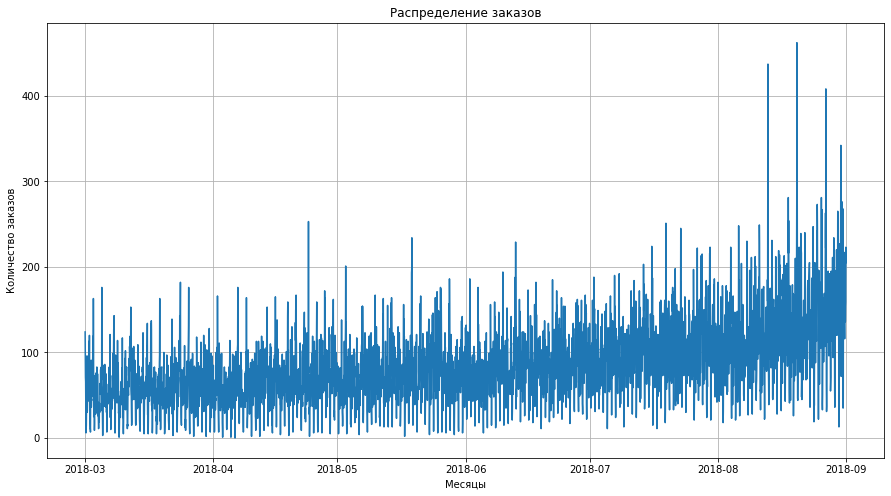

In [10]:
plt.figure(figsize=(15, 8))
plt.plot(data)
plt.title("Распределение заказов")
plt.xlabel("Месяцы")
plt.ylabel("Количество заказов")
plt.grid()
plt.show()

По графику видны выбрасы, но они не выглядят аномальными.

Тренды и сезонность

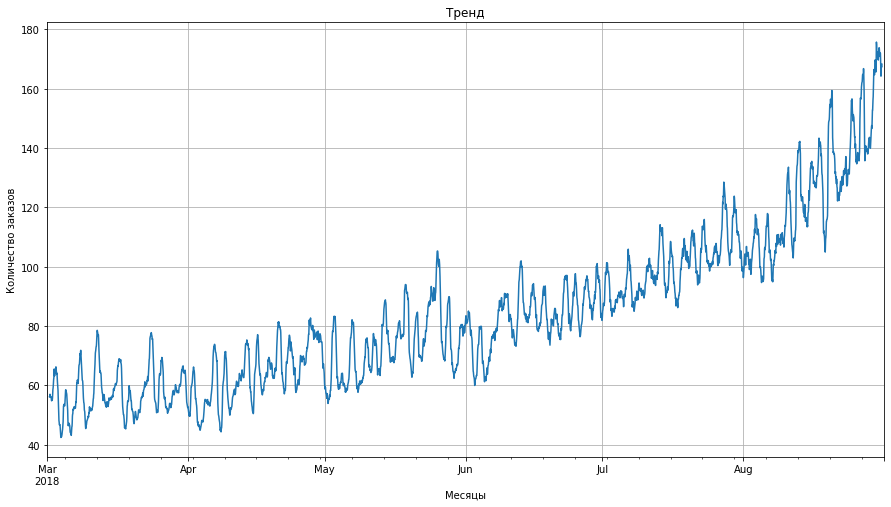

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 8))

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel("Месяцы")
plt.ylabel("Количество заказов")
plt.grid(True)
plt.show()

Видин растущий тренд заказов.

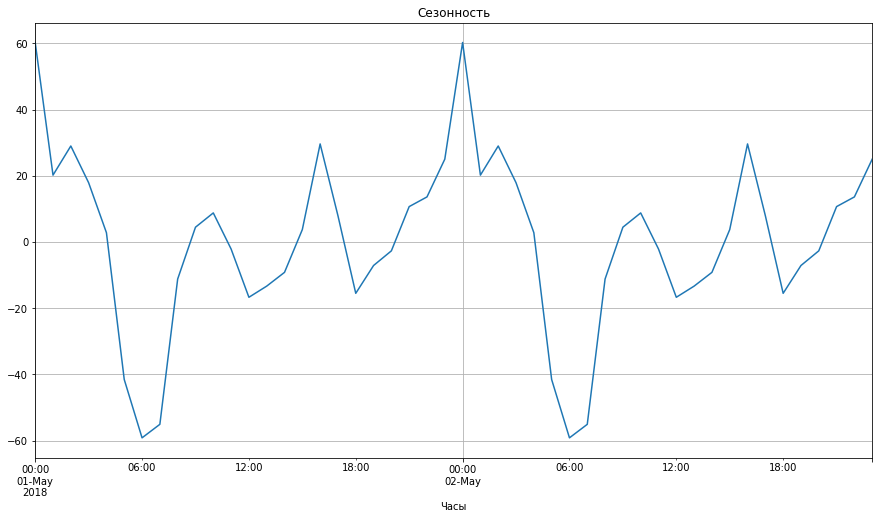

In [12]:
plt.figure(figsize=(15, 8))
decomposed.seasonal['2018-05-01':'2018-05-02'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel("Часы")
plt.grid(True)
plt.show()

Видим что пик приходится на 00 часов. Это и логично поскольку общественного транспорта уже а многим еще куда то да надо.

Чтобы во временном ряду снизить колебания, применим скользящее среднее.

In [13]:
data['rolling_mean'] = data.rolling(10).mean()

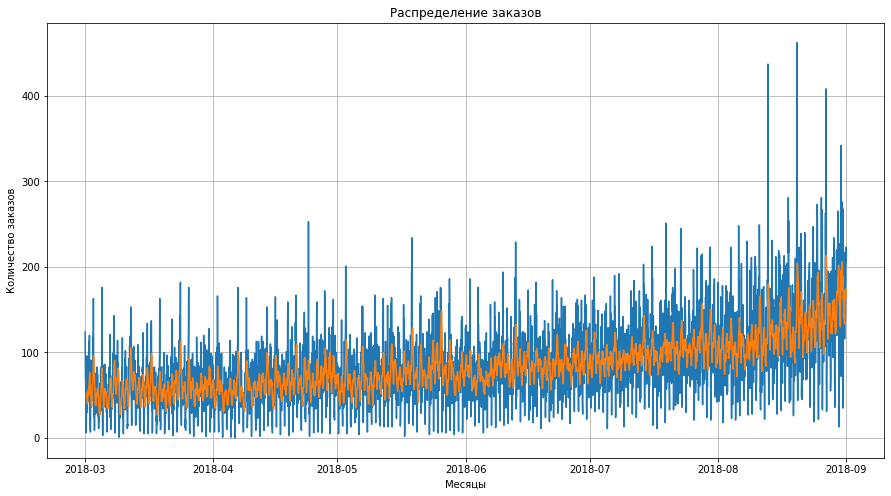

In [14]:
plt.figure(figsize=(15, 8))
plt.plot(data)
plt.title("Распределение заказов")
plt.xlabel("Месяцы")
plt.ylabel("Количество заказов")
plt.grid()
plt.show()

По графику видны выбрасы, но они не выглядят аномальными.

## Обучение

Обучим разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.

In [15]:
# def make_features(data, max_lag, rolling_mean_size):
    
#     data['day'] = data.index.day
#     data['dayofweek'] = data.index.dayofweek
#     data['hour'] = data.index.hour
    
#     for lag in range(1, max_lag + 1):
#         data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

#     data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


# make_features(data, 1, 1)

# train, test = train_test_split(data, shuffle=False, test_size=0.1)
# train = train.dropna()


# features_train  = train.drop('num_orders', axis=1)
# target_train = train[['num_orders']]
# features_test = test.drop('num_orders', axis=1)
# target_test = test[['num_orders']]

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    features = data.copy()

    features['day'] = features.index.day
    features['dayofweek'] = features.index.dayofweek
    features['hour'] = features.index.hour
    
    for lag in range(1, max_lag + 1):
        features['lag_{}'.format(lag)] = features['num_orders'].shift(lag)

    features['rolling_mean'] = features['num_orders'].shift().rolling(rolling_mean_size).mean()

    return features.dropna()

data = make_features(data, 24, 24)


# Разбиваем данные на тренировочную и тестовую выборки
train_data, test_data = train_test_split(data, shuffle=False, test_size=0.1)

# Отделяем целевой признак и матрицу признаков
target_train = train_data['num_orders']
features_train = train_data.drop('num_orders', axis=1)

target_test = test_data['num_orders']
features_test = test_data.drop('num_orders', axis=1)

tscv = TimeSeriesSplit(n_splits=5)

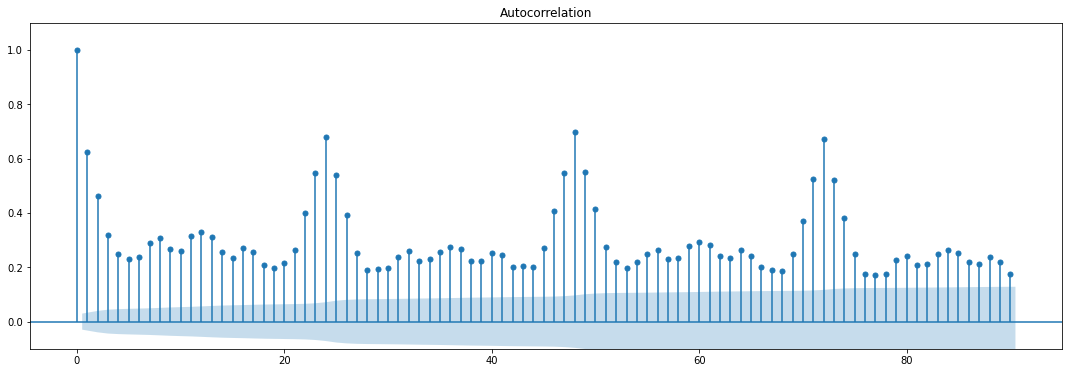

In [17]:
# Код 
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data['num_orders'],lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



В задании неоходимо обучить разные модели с различными гиперпараметрами, можно попробовать настроить гиперпараметры моделей.

случайный лес

In [18]:
# Создаем модель случайного леса
rf = RandomForestRegressor(random_state=42)
# Задаем сетку гиперпараметров
param_grid_forest = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}
# Инициализируем объект GridSearchCV
grid_search_forest = GridSearchCV(
    rf,
    param_grid_forest,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
# Обучаем модель
grid_search_forest.fit(features_train, target_train)

# Выводим лучшие гиперпараметры и значение RMSE на кросс-валидации
print('Лучшие гиперпараметры:', grid_search_forest.best_params_)
print('RMSE на кросс-валидации:', np.sqrt(-grid_search_forest.best_score_))

Лучшие гиперпараметры: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 500}
RMSE на кросс-валидации: 25.39909635836434


линейная регресия

In [19]:
# Создаем модель линейной регрессии
lr = LinearRegression()

# Задаем сетку гиперпараметров
param_grid_lr = {
    'normalize': [True, False]
}

# Инициализируем объект GridSearchCV
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=tscv, scoring='neg_mean_squared_error')

# Обучаем модель
grid_search_lr.fit(features_train, target_train)

# Выводим лучшие гиперпараметры и значение RMSE на кросс-валидации
print('Лучшие гиперпараметры:', grid_search_lr.best_params_)
print('RMSE на кросс-валидации:', np.sqrt(-grid_search_lr.best_score_))

Лучшие гиперпараметры: {'normalize': True}
RMSE на кросс-валидации: 27.34967463730232


градиентный бустинг

In [20]:
# Создаем модель градиентного бустинга
gbr = GradientBoostingRegressor(random_state=42)

# Задаем сетку гиперпараметров
param_grid_gbr = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1]
}

# Инициализируем объект GridSearchCV с использованием TimeSeriesSplit
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, cv=tscv, scoring='neg_mean_squared_error')

# Обучаем модель
grid_search_gbr.fit(features_train, target_train)

# Выводим лучшие гиперпараметры и значение RMSE на кросс-валидации
print('Лучшие гиперпараметры:', grid_search_gbr.best_params_)
print('RMSE на кросс-валидации:', np.sqrt(-grid_search_gbr.best_score_))

Лучшие гиперпараметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
RMSE на кросс-валидации: 25.168672040753385


Мы создаем модели, задаем сетки гиперпараметров для перебора, инициализируем объект GridSearchCV и обучаем модели с помощью метода fit. После обучения выводим лучшие гиперпараметры и значение RMSE на кросс-валидации.

## Тестирование

Теперь необходимо обучить различные модели с различными гиперпараметрами и проверить их на тестовой выборке заодно сравнив с обучающий. Чтобы непутатся и было понятнее сделаем как предложено в теории.

Линейная регресия

In [21]:
# Оцениваем качество модели на тестовой выборке
print('RMSE на тестовой выборке:', np.sqrt(mean_squared_error(target_test, grid_search_lr.predict(features_test))))

RMSE на тестовой выборке: 45.23457287220005


In [22]:
model_linear = LinearRegression(normalize=False)

# обучение модели на обучающей выборке
model1_linear = model_linear.fit(features_train, target_train)

# получим предсказания модели на тестовой выборке
predictions1_linear = model1_linear.predict(features_test)
rmse_lr1 = mean_squared_error(target_test, predictions1_linear) ** 0.5

# вычисление предсказаний для обучающей выборки
predictions2_linear = model1_linear.predict(features_train) 
rmse_lr2 = mean_squared_error(target_train, predictions2_linear) ** 0.5

print("RMSE обучающей выборки:", rmse_lr2)
print("RMSE тестовой выборки: ", rmse_lr1)

RMSE обучающей выборки: 25.844386222563447
RMSE тестовой выборки:  45.214640121413225


<div class="alert alert-info">
1. Что то нетак видимо с тестовой выборкой. Хотя исправил вроде как по рекомендации.
</div>

Случайный лес

In [23]:
# Оцениваем качество модели на тестовой выборке
print('RMSE на тестовой выборке:', np.sqrt(mean_squared_error(target_test, grid_search_forest.predict(features_test))))

RMSE на тестовой выборке: 43.33954013907629


In [24]:
# Создаем модель
model_forest = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10, min_samples_split=10)
# обучение модели на обучающей выборке
model1_forest = model_forest.fit(features_train, target_train)

# получим предсказания модели
predictions1_forest = model1_forest.predict(features_test) 
#result1_forest = mean_absolute_error(target_test,predictions1_forest)
rmse1_forest = mean_squared_error(target_test, predictions1_forest) ** 0.5

#model2_forest = model_forest.fit(features_test, target_test)

# получим предсказания модели
predictions2_forest = model1_forest.predict(features_train) 
#result2_forest = mean_absolute_error(target_train,predictions2_forest)
rmse2_forest = mean_squared_error(target_train, predictions2_forest) ** 0.5

print("RMSE обучающей выборки:", rmse2_forest)
print("RMSE тестовой выборки: ", rmse1_forest)


RMSE обучающей выборки: 15.455339254287258
RMSE тестовой выборки:  43.5220427426204


Градиентный бустинг

In [25]:
# Оцениваем качество модели на тестовой выборке
print('RMSE на тестовой выборке:', np.sqrt(mean_squared_error(target_test, grid_search_gbr.predict(features_test))))

RMSE на тестовой выборке: 42.124407212269084


In [26]:
# Создаем модель
model_grad = GradientBoostingRegressor(random_state=42, learning_rate=0.01, max_depth=3, n_estimators=500)

model1_grad = model_grad.fit(features_train, target_train) 

predictions1_grad = model1_grad.predict(features_test) # получим предсказания модели
#result1_grad = mean_absolute_error(target_test,predictions1_grad)
rmse1_grad = mean_squared_error(target_test, predictions1_grad) ** 0.5
#model2_grad = model_grad.fit(features_test, target_test) 


predictions2_grad = model1_grad.predict(features_train) # получим предсказания модели
#result2_grad = mean_absolute_error(target_train,predictions2_grad)
rmse2_grad= mean_squared_error(target_train, predictions2_grad) ** 0.5

print("RMSE обучающей выборки:", rmse2_grad)
print("RMSE тестовой выборки: ", rmse1_grad )


RMSE обучающей выборки: 21.514393671326314
RMSE тестовой выборки:  45.550380764645894


Для компания «Чётенькое такси» спрогнозировали количество заказов такси на следующий час. Построили модель для такого предсказания. Получили значение метрики RMSE на тестовой выборке не больше 48.
* Загрузили данные и выполнили их ресемплирование по одному часу.
* Проанализируйте данные. Видно, что количество заказов растет, в течении дня пик приходится на 00 часов, а спад на 6 утра.
* Обучили разные модели с различными гиперпараметрами. Сделали тестовую выборку размером 10% от исходных данных.
* Проверили данные на тестовой выборке и сравнили их собучающей выборкой.

In [27]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', round(RMSE(target_test, pred_previous), 3))


RMSE для проверки модели на адекватность: 58.882
